# Day_089

### 練習時間
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

In [1]:
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(x)
            x = BatchNormalization()(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Focal loss for multi-classification
   FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
"""
def focal_loss(y_true, y_pred, gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis = 1)
    return tf.reduce_mean(reduced_fl)  

def cross_entropy(y_true, y_pred):    
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
            
    reduce_ce = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = y_pred))
    return tf.reduce_mean(reduce_ce) 

"""Define the customized loss.
   combined_loss() :　0.3 * focal loss + 0.7 cross-entropy
"""
def combined_loss(w1 = 0.3, w2 = 0.7):
    def combined_loss_fixed(y_true, y_pred):
        f_loss = focal_loss(y_true, y_pred) 
        ce = cross_entropy(y_true, y_pred)
        c_loss = w1 * f_loss + w2 * ce
        return c_loss
    return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = combined_loss(), metrics = ["accuracy"], optimizer = optimizer)

    model.fit(x_train, y_train, 
              epochs = EPOCHS, 
              batch_size = BATCH_SIZE, 
              validation_data = (x_test, y_test), 
              shuffle = True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128) 

50000/50000 [==============================] - 15s 309us/step - loss: 1388.0070 - acc: 0.5243 - val_loss: 1451.1105 - val_acc: 0.4013
Epoch 10/25
50000/50000 [==============================] - 15s 298us/step - loss: 1377.9957 - acc: 0.5383 - val_loss: 1531.2577 - val_acc: 0.2946
Epoch 11/25
50000/50000 [==============================] - 16s 312us/step - loss: 1375.1210 - acc: 0.5416 - val_loss: 1443.7563 - val_acc: 0.4113
Epoch 12/25
50000/50000 [==============================] - 15s 307us/step - loss: 1371.2210 - acc: 0.5478 - val_loss: 1458.2003 - val_acc: 0.3945
Epoch 13/25
50000/50000 [==============================] - 15s 309us/step - loss: 1366.4780 - acc: 0.5545 - val_loss: 1512.0996 - val_acc: 0.3207
Epoch 14/25
50000/50000 [==============================] - 15s 307us/step - loss: 1363.0544 - acc: 0.5594 - val_loss: 1452.7629 - val_acc: 0.4021
Epoch 15/25
50000/50000 [==============================] - 15s 301us/step - loss: 1360.3379 - acc: 0.5623 - val_loss: 1521.7935 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 18s 366us/step - loss: 1493.0701 - acc: 0.3718 - val_loss: 1479.9031 - val_acc: 0.3625
Epoch 2/25
50000/50000 [==============================] - 16s 318us/step - loss: 1449.8667 - acc: 0.4330 - val_loss: 1462.2403 - val_acc: 0.3841
Epoch 3/25
50000/50000 [==============================] - 15s 310us/step - loss: 1432.1217 - acc: 0.4595 - val_loss: 1478.0324 - val_acc: 0.3645
Epoch 4/25
50000/50000 [==============================] - 16s 316us/step - loss: 1419.5769 - acc: 0.4772 - val_loss: 1501.0390 - val_acc: 0.3345
Epoch 5/25
50000/50000 [==============================] - 16s 319us/step - loss: 1410.6530 - acc: 0.4910 - val_loss: 1473.0916 - val_acc: 0.3682
Epoch 6/25
50000/50000 [==============================] - 16s 324us/step - loss: 1402.2361 - acc: 0.5026 - val_loss: 1526.9527 - val_acc: 0.2968
Epoch 7/25
50000/50000 [==============================] - 16s 325us/step - loss:

Epoch 22/25
50000/50000 [==============================] - 16s 311us/step - loss: 1327.6961 - acc: 0.6094 - val_loss: 1448.3875 - val_acc: 0.4083
Epoch 23/25
50000/50000 [==============================] - 15s 307us/step - loss: 1322.6514 - acc: 0.6171 - val_loss: 1417.0137 - val_acc: 0.4548
Epoch 24/25
50000/50000 [==============================] - 15s 303us/step - loss: 1319.9866 - acc: 0.6207 - val_loss: 1402.1310 - val_acc: 0.4739
Epoch 25/25
50000/50000 [==============================] - 15s 303us/step - loss: 1316.6915 - acc: 0.6248 - val_loss: 1435.9444 - val_acc: 0.4266


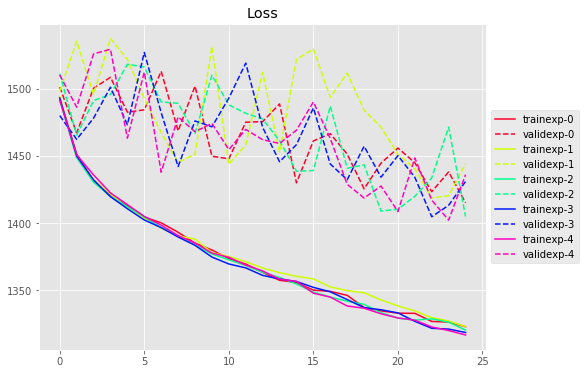

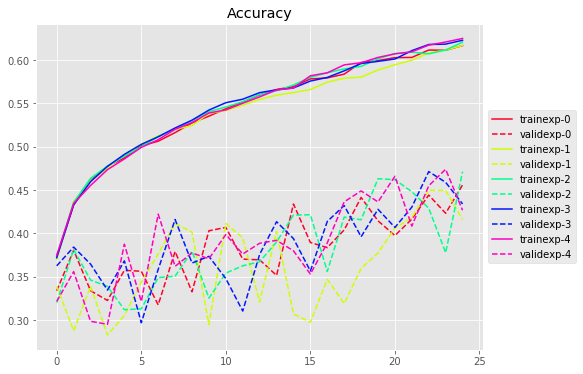

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
plt.style.use("ggplot")
%matplotlib inline

NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin = 0, vmax = NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm = cNorm, cmap = cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label = 'train' + cond, color = color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], '--', label = 'valid' + cond, color = color_bar[i])
plt.title("Loss")
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label = 'train' + cond, color = color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], '--', label = 'valid' + cond, color = color_bar[i])
plt.title("Accuracy")
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()